**Load data and libraries**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
import scipy
import sklearn
from datetime import datetime
import locale
import time
from random import randint
import math

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.inspection import permutation_importance
from sklearn.inspection import PartialDependenceDisplay

In [3]:
pd.set_option('display.min_rows', 30)

In [4]:
X_train = pd.read_csv("../Data for modelling/X_train_MP03.csv", header = 0, sep=',')
X_train.head()

,Hour,"['sat', 'sun', 'mon', 'tue', 'wed', 'thu', 'fri']_1","['sat', 'sun', 'mon', 'tue', 'wed', 'thu', 'fri']_2","['sat', 'sun', 'mon', 'tue', 'wed', 'thu', 'fri']_3","['sat', 'sun', 'mon', 'tue', 'wed', 'thu', 'fri']_4","['sat', 'sun', 'mon', 'tue', 'wed', 'thu', 'fri']_5","['sat', 'sun', 'mon', 'tue', 'wed', 'thu', 'fri']_6","['sat', 'sun', 'mon', 'tue', 'wed', 'thu', 'fri']_7",Holiday,is_kul_holiday,LC_TEMP_QCL3,LC_RAININ,LC_DAILYRAIN,LC_WINDSPEED
0,19,False,False,False,False,False,False,True,0,False,22.338912,0.000000,0.000000,0.305309
1,14,False,False,False,True,False,False,False,0,False,19.039233,0.000003,0.000009,0.237562
2,8,False,False,True,False,False,False,False,0,False,13.543212,0.000250,0.000222,0.040694
3,9,False,False,False,False,False,True,False,0,False,2.187339,0.000000,0.000000,0.174643
4,16,False,False,False,False,True,False,False,0,False,19.543486,0.000000,0.001102,0.761034


In [5]:
y_train = pd.read_csv("../Data for modelling/y_train_MP03.csv", header = 0, sep=',')
y_train.head()

,laeq
0,54.157333
1,56.597389
2,55.840289
3,50.856083
4,55.680639


In [6]:
X_test = pd.read_csv("../Data for modelling/X_test_MP03.csv", header = 0, sep=',')
X_test.head()

,Hour,"['sat', 'sun', 'mon', 'tue', 'wed', 'thu', 'fri']_1","['sat', 'sun', 'mon', 'tue', 'wed', 'thu', 'fri']_2","['sat', 'sun', 'mon', 'tue', 'wed', 'thu', 'fri']_3","['sat', 'sun', 'mon', 'tue', 'wed', 'thu', 'fri']_4","['sat', 'sun', 'mon', 'tue', 'wed', 'thu', 'fri']_5","['sat', 'sun', 'mon', 'tue', 'wed', 'thu', 'fri']_6","['sat', 'sun', 'mon', 'tue', 'wed', 'thu', 'fri']_7",Holiday,is_kul_holiday,LC_TEMP_QCL3,LC_RAININ,LC_DAILYRAIN,LC_WINDSPEED
0,23,False,False,False,True,False,False,False,0,False,10.390285,0.000000,0.000019,0.010015
1,15,False,True,False,False,False,False,False,1,False,18.693508,0.000000,0.000019,0.118935
2,16,False,False,True,False,False,False,False,0,False,12.659890,0.000008,0.002485,0.509660
3,15,False,False,False,False,False,False,True,0,False,25.085912,0.000000,0.000000,0.812948
4,23,False,False,False,False,False,True,False,0,False,7.584388,0.000000,0.000031,0.409575


In [7]:
y_test = pd.read_csv("../Data for modelling/y_test_MP03.csv", header = 0, sep=',')
y_test.head()

,laeq
0,51.781389
1,56.372861
2,55.976833
3,52.485639
4,52.144457


In [8]:
print(len(X_train), len(y_train), len(X_test), len(y_test))
#Adds up to 8760, imputation worked

7008 7008 1752 1752


**Preprocessing/feature engineering (almost all of this section was moved to preprocessing notebook)**

In [15]:
#Keep only hours between 10pm and 6am in train data
X_train['Hour'] = X_train['Hour'].astype('int')
X_trainnight = X_train[(X_train['Hour'] < 7) | (X_train['Hour'] > 22)]

hour_mapping = {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 23: 7}
X_trainnight['Hour'] = X_trainnight['Hour'].replace(hour_mapping)
display(X_trainnight)
len(X_trainnight)

C:\Users\Axl Wynants\AppData\Local\Temp\ipykernel_14988\36126958.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_trainnight['Hour'] = X_trainnight['Hour'].replace(hour_mapping)


,Hour,"['sat', 'sun', 'mon', 'tue', 'wed', 'thu', 'fri']_1","['sat', 'sun', 'mon', 'tue', 'wed', 'thu', 'fri']_2","['sat', 'sun', 'mon', 'tue', 'wed', 'thu', 'fri']_3","['sat', 'sun', 'mon', 'tue', 'wed', 'thu', 'fri']_4","['sat', 'sun', 'mon', 'tue', 'wed', 'thu', 'fri']_5","['sat', 'sun', 'mon', 'tue', 'wed', 'thu', 'fri']_6","['sat', 'sun', 'mon', 'tue', 'wed', 'thu', 'fri']_7",Holiday,is_kul_holiday,LC_TEMP_QCL3,LC_RAININ,LC_DAILYRAIN,LC_WINDSPEED
7,3,False,True,False,False,False,False,False,0,False,5.454536,0.000009,0.001509,0.025185
12,6,False,False,False,False,False,False,True,1,True,4.349245,0.000009,0.000019,0.071867
16,3,False,False,False,False,True,False,False,0,True,7.482413,0.000000,0.000031,0.473912
21,5,True,False,False,False,False,False,False,1,False,21.291304,0.000000,0.000056,0.037454
23,2,False,False,False,False,False,False,True,0,False,13.348660,0.000000,0.000157,0.188380
24,3,False,False,False,False,False,False,True,0,False,13.086615,0.000241,0.000167,0.006173
25,4,False,False,False,True,False,False,False,0,False,15.716055,0.000000,0.000000,0.021759
39,1,False,False,False,False,True,False,False,0,False,3.273054,0.000000,0.001265,0.556514
40,3,False,False,False,True,False,False,False,0,False,9.978312,0.000009,0.000019,0.048981
41,0,False,False,False,False,False,True,False,0,False,-0.558056,0.000019,0.001444,0.066204


2324

In [16]:
#Keep only hours between 10pm and 6am in train data
X_test['Hour'] = X_test['Hour'].astype('int')
X_testnight = X_test[(X_test['Hour'] < 7) | (X_test['Hour'] > 22)]

hour_mapping = {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 23: 7}
X_testnight['Hour'] = X_testnight['Hour'].replace(hour_mapping)
display(X_testnight)
len(X_testnight)

C:\Users\Axl Wynants\AppData\Local\Temp\ipykernel_14988\4035739851.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_testnight['Hour'] = X_testnight['Hour'].replace(hour_mapping)


,Hour,"['sat', 'sun', 'mon', 'tue', 'wed', 'thu', 'fri']_1","['sat', 'sun', 'mon', 'tue', 'wed', 'thu', 'fri']_2","['sat', 'sun', 'mon', 'tue', 'wed', 'thu', 'fri']_3","['sat', 'sun', 'mon', 'tue', 'wed', 'thu', 'fri']_4","['sat', 'sun', 'mon', 'tue', 'wed', 'thu', 'fri']_5","['sat', 'sun', 'mon', 'tue', 'wed', 'thu', 'fri']_6","['sat', 'sun', 'mon', 'tue', 'wed', 'thu', 'fri']_7",Holiday,is_kul_holiday,LC_TEMP_QCL3,LC_RAININ,LC_DAILYRAIN,LC_WINDSPEED
0,7,False,False,False,True,False,False,False,0,False,10.390285,0.000000,0.000019,0.010015
4,7,False,False,False,False,False,True,False,0,False,7.584388,0.000000,0.000031,0.409575
8,3,False,True,False,False,False,False,False,1,False,11.450403,0.000000,0.000056,0.021481
9,2,False,True,False,False,False,False,False,0,False,5.678391,0.000000,0.000153,0.310527
12,6,False,False,False,True,False,False,False,0,False,-6.802101,0.000019,0.001426,0.016620
14,2,True,False,False,False,False,False,False,0,False,9.403725,0.000048,0.000065,0.027963
16,5,False,False,False,False,False,True,False,0,False,7.900631,0.000952,0.004937,0.044336
19,2,True,False,False,False,False,False,False,0,False,11.655217,0.000000,0.000000,0.030293
22,2,False,True,False,False,False,False,False,0,True,7.655315,0.000605,0.001796,0.373265
26,0,False,False,True,False,False,False,False,0,False,24.570398,0.000231,0.000123,0.033287


596

In [17]:
#Trig encode night hours in train set
X_trainnight['hour_sin'] = X_trainnight['Hour'].apply(lambda x: math.sin(2*math.pi * x / 8))
X_trainnight['hour_cos'] = X_trainnight['Hour'].apply(lambda x: math.cos(2*math.pi * x / 8))
X_trainnight = X_trainnight.drop('Hour', axis = 1)
display(X_trainnight)

C:\Users\Axl Wynants\AppData\Local\Temp\ipykernel_14988\3675330418.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_trainnight['hour_sin'] = X_trainnight['Hour'].apply(lambda x: math.sin(2*math.pi * x / 8))
C:\Users\Axl Wynants\AppData\Local\Temp\ipykernel_14988\3675330418.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_trainnight['hour_cos'] = X_trainnight['Hour'].apply(lambda x: math.cos(2*math.pi * x / 8))


,"['sat', 'sun', 'mon', 'tue', 'wed', 'thu', 'fri']_1","['sat', 'sun', 'mon', 'tue', 'wed', 'thu', 'fri']_2","['sat', 'sun', 'mon', 'tue', 'wed', 'thu', 'fri']_3","['sat', 'sun', 'mon', 'tue', 'wed', 'thu', 'fri']_4","['sat', 'sun', 'mon', 'tue', 'wed', 'thu', 'fri']_5","['sat', 'sun', 'mon', 'tue', 'wed', 'thu', 'fri']_6","['sat', 'sun', 'mon', 'tue', 'wed', 'thu', 'fri']_7",Holiday,is_kul_holiday,LC_TEMP_QCL3,LC_RAININ,LC_DAILYRAIN,LC_WINDSPEED,hour_sin,hour_cos
7,False,True,False,False,False,False,False,0,False,5.454536,0.000009,0.001509,0.025185,7.071068e-01,-7.071068e-01
12,False,False,False,False,False,False,True,1,True,4.349245,0.000009,0.000019,0.071867,-1.000000e+00,-1.836970e-16
16,False,False,False,False,True,False,False,0,True,7.482413,0.000000,0.000031,0.473912,7.071068e-01,-7.071068e-01
21,True,False,False,False,False,False,False,1,False,21.291304,0.000000,0.000056,0.037454,-7.071068e-01,-7.071068e-01
23,False,False,False,False,False,False,True,0,False,13.348660,0.000000,0.000157,0.188380,1.000000e+00,6.123234e-17
24,False,False,False,False,False,False,True,0,False,13.086615,0.000241,0.000167,0.006173,7.071068e-01,-7.071068e-01
25,False,False,False,True,False,False,False,0,False,15.716055,0.000000,0.000000,0.021759,1.224647e-16,-1.000000e+00
39,False,False,False,False,True,False,False,0,False,3.273054,0.000000,0.001265,0.556514,7.071068e-01,7.071068e-01
40,False,False,False,True,False,False,False,0,False,9.978312,0.000009,0.000019,0.048981,7.071068e-01,-7.071068e-01
41,False,False,False,False,False,True,False,0,False,-0.558056,0.000019,0.001444,0.066204,0.000000e+00,1.000000e+00


In [18]:
#Trig encode night hours in test set
X_testnight['hour_sin'] = X_testnight['Hour'].apply(lambda x: math.sin(2*math.pi * x / 8))
X_testnight['hour_cos'] = X_testnight['Hour'].apply(lambda x: math.cos(2*math.pi * x / 8))
X_testnight = X_testnight.drop('Hour', axis = 1)
display(X_testnight)

C:\Users\Axl Wynants\AppData\Local\Temp\ipykernel_14988\687310159.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_testnight['hour_sin'] = X_testnight['Hour'].apply(lambda x: math.sin(2*math.pi * x / 8))
C:\Users\Axl Wynants\AppData\Local\Temp\ipykernel_14988\687310159.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_testnight['hour_cos'] = X_testnight['Hour'].apply(lambda x: math.cos(2*math.pi * x / 8))


,"['sat', 'sun', 'mon', 'tue', 'wed', 'thu', 'fri']_1","['sat', 'sun', 'mon', 'tue', 'wed', 'thu', 'fri']_2","['sat', 'sun', 'mon', 'tue', 'wed', 'thu', 'fri']_3","['sat', 'sun', 'mon', 'tue', 'wed', 'thu', 'fri']_4","['sat', 'sun', 'mon', 'tue', 'wed', 'thu', 'fri']_5","['sat', 'sun', 'mon', 'tue', 'wed', 'thu', 'fri']_6","['sat', 'sun', 'mon', 'tue', 'wed', 'thu', 'fri']_7",Holiday,is_kul_holiday,LC_TEMP_QCL3,LC_RAININ,LC_DAILYRAIN,LC_WINDSPEED,hour_sin,hour_cos
0,False,False,False,True,False,False,False,0,False,10.390285,0.000000,0.000019,0.010015,-7.071068e-01,7.071068e-01
4,False,False,False,False,False,True,False,0,False,7.584388,0.000000,0.000031,0.409575,-7.071068e-01,7.071068e-01
8,False,True,False,False,False,False,False,1,False,11.450403,0.000000,0.000056,0.021481,7.071068e-01,-7.071068e-01
9,False,True,False,False,False,False,False,0,False,5.678391,0.000000,0.000153,0.310527,1.000000e+00,6.123234e-17
12,False,False,False,True,False,False,False,0,False,-6.802101,0.000019,0.001426,0.016620,-1.000000e+00,-1.836970e-16
14,True,False,False,False,False,False,False,0,False,9.403725,0.000048,0.000065,0.027963,1.000000e+00,6.123234e-17
16,False,False,False,False,False,True,False,0,False,7.900631,0.000952,0.004937,0.044336,-7.071068e-01,-7.071068e-01
19,True,False,False,False,False,False,False,0,False,11.655217,0.000000,0.000000,0.030293,1.000000e+00,6.123234e-17
22,False,True,False,False,False,False,False,0,True,7.655315,0.000605,0.001796,0.373265,1.000000e+00,6.123234e-17
26,False,False,True,False,False,False,False,0,False,24.570398,0.000231,0.000123,0.033287,0.000000e+00,1.000000e+00


In [20]:
#Get noise for only night hours in train set
noisedftrain = pd.concat([X_train, y_train], axis = 1)
noisedftrain = noisedftrain[(noisedftrain['Hour'] < 7) | (noisedftrain['Hour'] > 22)]

y_trainnight = noisedftrain['laeq']

display(y_trainnight)
len(y_trainnight)

7       48.250500
12      46.202333
16      45.360611
21      44.731278
23      50.575806
24      47.159222
25      44.857750
39      53.868889
40      51.019472
41      51.730361
44      51.548083
45      50.183667
47      46.282778
48      46.432611
57      46.321083
          ...    
6968    47.583329
6969    49.427083
6975    55.839028
6976    48.276417
6984    51.557306
6987    51.088917
6991    49.413000
6997    51.009722
6999    44.638667
7001    45.244722
7002    49.514361
7004    48.784111
7005    46.197972
7006    51.896166
7007    52.072278
Name: laeq, Length: 2324, dtype: float64

2324

In [21]:
#Get noise for only night hours in the test set
noisedftest = pd.concat([X_test, y_test], axis = 1)
noisedftest = noisedftest[(noisedftest['Hour'] < 7) | (noisedftest['Hour'] > 22)]

y_testnight = noisedftest['laeq']

display(y_testnight)
len(y_testnight)

0       51.781389
4       52.144457
8       44.919139
9       50.954833
12      49.259278
14      44.980222
16      47.020311
19      44.862944
22      44.730639
26      48.690611
29      45.835944
30      44.784611
31      49.122833
34      49.783694
35      50.872806
          ...    
1709    48.328056
1717    48.820806
1718    45.835333
1719    54.598667
1723    53.394750
1726    51.433028
1729    46.610500
1733    49.525639
1734    48.852278
1735    46.229250
1736    45.516667
1740    45.862972
1744    44.905667
1745    54.407167
1746    50.853806
Name: laeq, Length: 596, dtype: float64

596

In [22]:
#Convert target variables to 1D arrays
y_trainnight = np.ravel(y_trainnight)
y_testnight = np.ravel(y_testnight)

**Training/Hyperparameter optimization for night only**

In [29]:
#Random forest
model = RandomForestRegressor()
model.fit(X_trainnight, y_trainnight)
predictions = model.predict(X_testnight)

In [30]:
#Random forest evaluation
mse = mean_squared_error(y_testnight, predictions)
mae = mean_absolute_error(y_testnight, predictions)
r2 = r2_score(y_testnight, predictions)

print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print("R-squared Score (R2):", r2)

Mean Squared Error (MSE): 2.7358024910538328
Mean Absolute Error (MAE): 1.2062110940610973
R-squared Score (R2): 0.6884662917707649


In [74]:
#Try randomized search to save on computation time
start_time = time.time()
param_dist = {
    'n_estimators': [200, 300, 400, 500, 600, 700, 800, 900, 1000],  # Number of trees in the forest
    'max_features': [1.0, 'sqrt'],  # Number of features to consider at every split
    'max_depth': [None] + list(range(5, 30, 5)), #Maximum depth of the trees
    'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9, 10],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],  # Minimum number of samples required to be at a leaf node 
}

random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_dist,
    n_iter=30,  # Number of parameter settings that are sampled
    scoring='neg_mean_squared_error',  # Evaluation metric
    cv=5,  # Number of cross-validation folds
    verbose=1
)

random_search.fit(X_trainnight, y_trainnight)
bestr_model = random_search.best_estimator_
best_params = random_search.best_params_

end_time = time.time()
elapsed_time = end_time - start_time

print(best_params)
#Best parameters {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 1.0, 'max_depth': None}

Fitting 5 folds for each of 30 candidates, totalling 150 fits
{'n_estimators': 400, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': 1.0, 'max_depth': 15}


In [75]:
print("Time it took to train: {:.2f} seconds".format(elapsed_time))

Time it took to train: 781.80 seconds


**SageMaker tuned model, run these cells to run the model**

In [32]:
#So this cell is the random search-tuned model with its final hyperparameters
finalmodel = RandomForestRegressor()
bestparams = {'n_estimators': 200, 'min_samples_split': 2, 'max_depth': None, 'min_samples_leaf': 1, 'max_features': 1.0}
finalmodel.set_params(**bestparams)
finalmodel.fit(X_trainnight, y_trainnight)

RandomForestRegressor(n_estimators=200)

In [35]:
#Evaluating randomized search-tuned model
predictions2 = finalmodel.predict(X_testnight)

predictions2 = pd.Series(predictions2)

mse = mean_squared_error(y_testnight, predictions2)
mae = mean_absolute_error(y_testnight, predictions2)
r2 = r2_score(y_testnight, predictions2)

print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print("R-squared Score (R2):", r2)

Mean Squared Error (MSE): 2.729024610292808
Mean Absolute Error (MAE): 1.2014918810401163
R-squared Score (R2): 0.6892381085719859


Elapsed time to compute the importances: 15.022 seconds


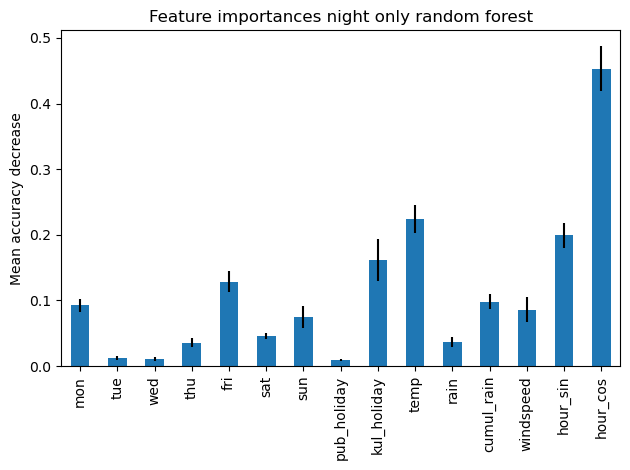

In [37]:
start_time = time.time()
result = permutation_importance(
    finalmodel, X_testnight, y_testnight, n_repeats=10, random_state=42, n_jobs=2
)
elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

forest_importances = pd.Series(result.importances_mean, index=['mon', 'tue', 'wed', 'thu', 'fri', 'sat', 'sun', 'pub_holiday', 'kul_holiday',
                                                               'temp', 'rain', 'cumul_rain', 'windspeed', 'hour_sin', 'hour_cos'])
forest_importances.to_csv("RFnightimportances.csv")

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances night only random forest")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()
#This plot measures how much the accuracy of the predictions decrease when one feature is randomly permuted and the others
#Kept constant. In other words, it measures how much the variable contributes to the predictions


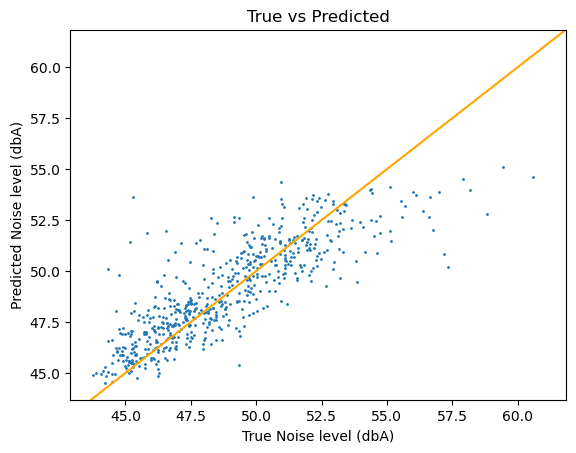

In [83]:
#Plot predicted values against true ones
plt.scatter(y_testnight, predictions2, s=1)
plt.axline((48, 48), (61, 61), color = 'orange')
plt.xlabel('True Noise level (dbA)')
plt.ylabel('Predicted Noise level (dbA)')
plt.title('True vs Predicted')
plt.show()

#Now very high observations are underpredicted systematically

In [86]:
#nr of over/underestimations to see if the model is particularly biased up/down
num = 0
over = 0
for i in y_testnight:
    if i < predictions2[[num]]:
        over += 1
    num +=1
print("Overpredictions:", over, "Underpredictions:", len(y_testnight) - over)

Overpredictions: 343 Underpredictions: 253


**Partial effect of each predictor at night**

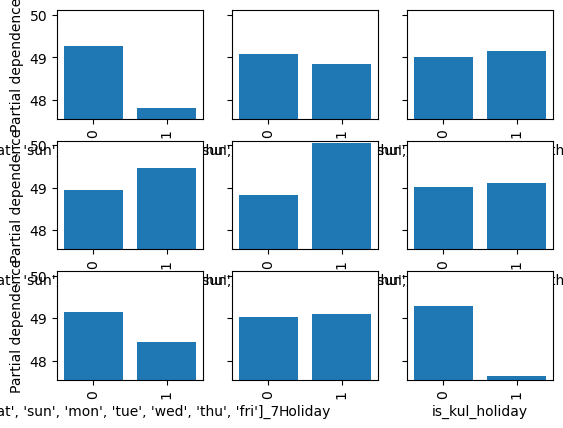

In [87]:
#Plot partial dependence of weekdays + holiday (aligns with the feature importance plot)
PartialDependenceDisplay.from_estimator(finalmodel, X_trainnight, [0, 1, 2, 3, 4, 5, 6, 7, 8], 
                                        categorical_features= [True, True, True, True, True, True, True, True, 
                                                              True, False, False, False, False, False, False])

#At night KUL holidays have the strongest effect

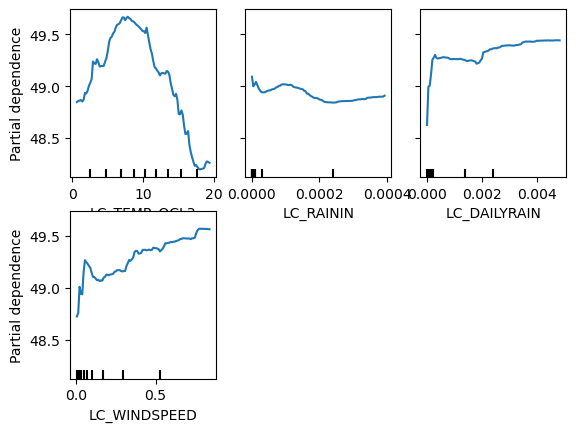

In [88]:
#Plot partial dependence of continuous variables
PartialDependenceDisplay.from_estimator(finalmodel, X_trainnight, [9, 10, 11, 12])

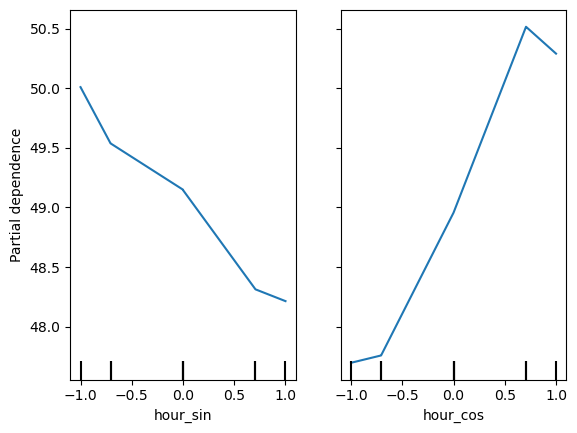

In [90]:
#Plot partial dependence of hour
PartialDependenceDisplay.from_estimator(finalmodel, X_trainnight, [13, 14])